# Bayesian Neural Network (BNN) models evaluation

Import necessary libraries and functions:

In [32]:
import os
import pickle
import pandas as pd
import jax.numpy as jnp
import jax.random as random
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, brier_score_loss
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive 
from numpyro.diagnostics import summary
import seaborn as sns
import matplotlib.pyplot as plt

Load validation data:

In [33]:
val_df = pd.read_csv("data/processed/validation.csv")
X_val = jnp.array(val_df.drop(columns="label"))
y_val = jnp.array(val_df["label"])

Mapping for prior precisions:

In [34]:
precision_prior_map = {
    0.01: (2.0, 200.0),  
    0.1: (2.0, 20.0),   
    1.0: (2.0, 2.0)   
}

Define the BNN model:

In [ ]:
def bnn_model(X, y=None, hidden_dim=10, precision_prior=1.0):
    n, m = X.shape
    alpha, beta = precision_prior_map[precision_prior]
    precision_nn = numpyro.sample('precision_nn', dist.Gamma(alpha, beta))

    # First layer: biases and weights
    with numpyro.plate('l1_hidden', hidden_dim):
        b1 = numpyro.sample(
            'nn_b1', dist.Normal(0.0, jnp.sqrt(1.0 / (precision_nn*m)))
        )
        with numpyro.plate('l1_feat', m):
            w1 = numpyro.sample(
                'nn_w1', dist.Normal(0.0, jnp.sqrt(1.0 / (precision_nn*m)))
            )

    # Second (output) layer: weights and bias
    with numpyro.plate('l2_hidden', hidden_dim):
        w2 = numpyro.sample(
            'nn_w2', dist.Normal(0.0, jnp.sqrt(1.0 / (precision_nn*hidden_dim)))
        )
    b2 = numpyro.sample(
        'nn_b2', dist.Normal(0.0, jnp.sqrt(1.0 / (precision_nn*hidden_dim)))
    )

    # Forward pass with ReLU activation
    hidden = jnp.maximum(X @ w1 + b1, 0)
    logits = hidden @ w2 + b2

    # Bernoulli likelihood
    with numpyro.plate('data', n):
        numpyro.sample('obs', dist.Bernoulli(logits=logits), obs=y)

function to flatten chains if multiple MCMC chains are present:

In [36]:
def flatten_chains(posterior_samples):
    """Flatten chains in posterior samples if they exist."""
    flattened = {}
    for k, v in posterior_samples.items():
        if v.ndim >= 2 and 1 < v.shape[0] <= 10:  # small chain count
            flattened[k] = v.reshape(-1, *v.shape[2:])
        else:
            flattened[k] = v
    return flattened

Function to compute Expected Calibration Error (ECE):

In [37]:
def compute_ece(probabilities, true_labels, n_bins=10):
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_indices = np.digitize(probabilities, bin_edges) - 1

    ece = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if np.any(bin_mask):
            bin_confidence = probabilities[bin_mask].mean()
            bin_accuracy = true_labels[bin_mask].mean()
            ece += np.abs(bin_confidence - bin_accuracy) * bin_mask.mean()
    return ece

Flatten values from numpyro summary dictionary:

In [38]:
def flatten_summary_values(stats_dict, key):
    """Flatten all scalar/array values for a given key from summary() output."""
    vals = []
    for stats in stats_dict.values():
        if key in stats:
            arr = np.array(stats[key]).flatten()
            vals.extend(arr.tolist())
    return vals

Load all sample files from results folder:

In [39]:
sample_files = [f for f in os.listdir("results/bnn/") if f.endswith(".pkl")]
evaluation_logs = []
records_rhat = []
records_ess = []
main_key = random.PRNGKey(123)

Evaluate each posterior sample file:

In [40]:
for filename in sample_files:

    id = filename.replace("_samples.pkl", "")
    path = os.path.join("results/bnn/", filename)
    print(f"Evaluating {id}")

    try:
        # Extract method, width, and precision prior from filename
        parts = id.split("_")
        method = parts[0]
        width = int([p[1:] for p in parts if p.startswith("w")][0])
        precision_prior = float([p[1:] for p in parts if p.startswith("p")][0])
        
        # Load posterior samples
        with open(path, "rb") as f:
            samples_raw = pickle.load(f)
        
        # For MCMC, compute convergence diagnostics
        if method == "mcmc":
             samples_summ = summary(samples_raw, group_by_chain=True)

             # Extract R-hat values
             samples_rhat = flatten_summary_values(samples_summ, "r_hat")
             for val in samples_rhat:
                 records_rhat.append({
                     "method": method,
                     "width": width,
                     "precision_prior": precision_prior,
                     "rhat": val
                 })

             # Extract effective sample size
             ess_key = "ess_bulk" if any("ess_bulk" in s for s in samples_summ.values()) else "n_eff"
             ess_vals = flatten_summary_values(samples_summ, ess_key)
             for val in ess_vals:
                 records_ess.append({
                     "method_label": method,
                     "width": width,
                     "precision_prior": precision_prior,
                     "ess": val
                 })

        # Flatten chains for prediction
        samples = flatten_chains(samples_raw)

        # Summarise precision_nn posterior
        if "precision_nn" in samples:
            prec_samples = samples["precision_nn"].reshape(-1)
            prec_mean = float(np.mean(prec_samples))
            prec_median = float(np.median(prec_samples))
            prec_ci_lower = float(np.quantile(prec_samples, 0.025))
            prec_ci_upper = float(np.quantile(prec_samples, 0.975))
        else:
            prec_mean = prec_median = prec_ci_lower = prec_ci_upper = np.nan
        
        # Predictive posterior
        predictive = Predictive(
            bnn_model, posterior_samples=samples, return_sites=["obs"],
            parallel=True
        )

        model_key, main_key = random.split(main_key)

        preds = predictive(
            model_key, X_val,hidden_dim=width, precision_prior=precision_prior
        )['obs']  

        # Compute mean predicted probabilities and labels
        pred_probs = preds.mean(axis=0)
        pred_labels = (pred_probs >= 0.5).astype(int)

        # Compute metrics
        precision_score_val = precision_score(y_val, pred_labels)
        recall_score_val = recall_score(y_val, pred_labels)
        f1_score_val = f1_score(y_val, pred_labels)

        true_labels_np = np.array(y_val)
        pred_probs_np = np.array(pred_probs)

        logloss_val = log_loss(true_labels_np, pred_probs_np)
        brier_val = brier_score_loss(true_labels_np, pred_probs_np)
        ece_val = compute_ece(pred_probs_np, true_labels_np, n_bins=10)

        # Store evaluation metrics
        evaluation_logs.append({
            'id': id,
            'precision': precision_score_val,
            'recall': recall_score_val,
            'f1': f1_score_val,
            'log_loss': logloss_val,
            'brier': brier_val,
            'ece': ece_val,
            'prec_mean': prec_mean,
            'prec_median': prec_median,
            'prec_ci_lower': prec_ci_lower,
            'prec_ci_upper': prec_ci_upper
        })

    except Exception as e:
        print(f"Failed to evaluate {id}: {e}")
        evaluation_logs.append({
            'id': id,
            'precision': 'error',
            'recall': 'error',
            'f1': f'error: {str(e)}',
            'prec_mean': np.nan,
            'prec_median': np.nan,
            'prec_ci_lower': np.nan,
            'prec_ci_upper': np.nan
        })

rhat_df = pd.DataFrame(records_rhat)
ess_df = pd.DataFrame(records_ess)
eval_df = pd.DataFrame(evaluation_logs)

rhat_df.to_csv('results/rhat_diagnostic.csv', index=False)
ess_df.to_csv('results/ess_diagnostic.csv', index=False)
eval_df.to_csv('results/evaluation_metrics.csv', index=False)
print("Evaluation metrics saved to results/evaluation_metrics.csv")

Evaluating mcmc_NUTS_w10_p0.01
Evaluating mcmc_NUTS_w10_p0.1
Evaluating mcmc_NUTS_w10_p1
Evaluating mcmc_NUTS_w14_p0.01
Evaluating mcmc_NUTS_w14_p0.1
Evaluating mcmc_NUTS_w14_p1
Evaluating mcmc_NUTS_w5_p0.01
Evaluating mcmc_NUTS_w5_p0.1
Evaluating mcmc_NUTS_w5_p1
Evaluating vi_AutoDiag_w10_p0.01
Evaluating vi_AutoDiag_w10_p0.1
Evaluating vi_AutoDiag_w10_p1
Evaluating vi_AutoDiag_w14_p0.01
Evaluating vi_AutoDiag_w14_p0.1
Evaluating vi_AutoDiag_w14_p1
Evaluating vi_AutoDiag_w5_p0.01
Evaluating vi_AutoDiag_w5_p0.1
Evaluating vi_AutoDiag_w5_p1
Evaluating vi_AutoMult_w10_p0.01
Evaluating vi_AutoMult_w10_p0.1
Evaluating vi_AutoMult_w10_p1
Evaluating vi_AutoMult_w14_p0.01
Evaluating vi_AutoMult_w14_p0.1
Evaluating vi_AutoMult_w14_p1
Evaluating vi_AutoMult_w5_p0.01
Evaluating vi_AutoMult_w5_p0.1
Evaluating vi_AutoMult_w5_p1
Evaluation metrics saved to results/evaluation_metrics.csv


Merge evaluation metrics with experiment log:

In [41]:
exp_df = pd.read_csv("results/experiment_log.csv")
results_df = pd.merge(exp_df, eval_df, on="id", how="inner")

List of metric columns to be converted to numeric:

In [42]:
metric_cols = [
    "precision", "recall", "f1", "log_loss", "brier", "ece", "duration_seconds"
]
for col in metric_cols:
    results_df[col] = pd.to_numeric(results_df[col], errors="coerce")

Function to create a readable label for each method:

In [43]:
def label_method(row):
    if row["method"] == "mcmc":
        return "NUTS"
    elif row["method"] == "vi":
        if row["guide"] == "AutoDiag":
            return "MFG-VI"
        elif row["guide"] == "AutoMult":
            return "MVG-VI"
    return row["method"]  

Apply the label_method function:

In [44]:
results_df["method_label"] = results_df.apply(label_method, axis=1)

Aggregate metrics by method_label, computing mean and standard deviation:

In [45]:
results_summ_df = (
    results_df.groupby("method_label")[metric_cols]
    .agg(["mean", "std"])
)
results_summ_df.columns = [f"{col}_{stat}" for col, stat in results_summ_df.columns]
results_summ_df = results_summ_df.sort_values("f1_mean", ascending=False).reset_index()
results_summ_df

,method_label,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,log_loss_mean,log_loss_std,brier_mean,brier_std,ece_mean,ece_std,duration_seconds_mean,duration_seconds_std
0,NUTS,0.967350,0.013348,0.921605,0.027561,0.943588,0.011580,0.052837,0.013011,0.015158,0.003638,0.010935,0.002566,1787.951111,534.138713
1,MFG-VI,0.974601,0.018634,0.820370,0.038188,0.890392,0.024158,0.135014,0.027130,0.031834,0.006298,0.029091,0.017595,21.488889,5.196940
2,MVG-VI,0.965791,0.018415,0.820370,0.022567,0.886786,0.009310,0.102407,0.007902,0.027834,0.001608,0.020492,0.004349,15.520000,5.211718


Save the summarized metrics:

In [46]:
results_summ_df.to_csv("results/method_summary.csv", index=False)

Convert 'width' column to string for categorical plotting:

In [47]:
results_df["width_cat"] = results_df["width"].astype(str)

Set Seaborn plotting style:

In [48]:
sns.set_style("white")

Create a facet grid to plot F1 score vs width for each method, coloured by prior precision:

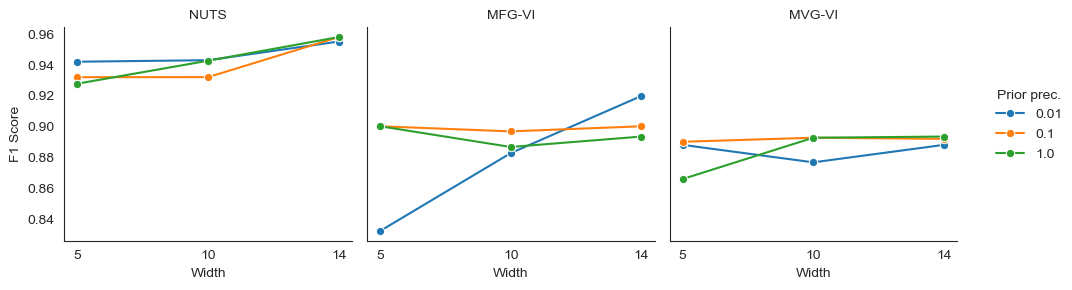

In [49]:
g = sns.FacetGrid(
    results_df,
    col="method_label",
    hue="precision_prior",
    col_order=["NUTS", "MFG-VI", "MVG-VI"],
    sharey=True,
    sharex=True,
    col_wrap=3,
    height=3.0,
    aspect=1
)

g.map_dataframe(
    sns.lineplot,
    x="width_cat",
    y="f1",
    marker="o"
)

g.add_legend(title="Prior prec.")
g._legend.set_bbox_to_anchor((1.1, 0.55))
g._legend.set_frame_on(False)  

g.set_axis_labels("Width", "F1 Score")
g.set_titles("{col_name}")

plt.tight_layout()
plt.savefig(
  "figures/f1_width_cat_precisionprior_by_method.png", dpi=300, 
  bbox_inches="tight"
)
plt.show()

Similar facet grid for plotting posterior precision with error bars:

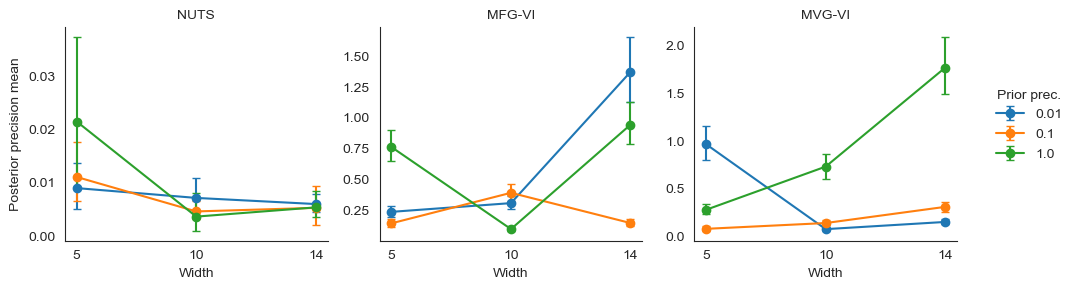

In [56]:
g = sns.FacetGrid(
    results_df,
    col="method_label",
    hue="precision_prior",
    col_order=["NUTS", "MFG-VI", "MVG-VI"],
    sharey=False,
    sharex=True,
    col_wrap=3,
    height=3.0,
    aspect=1
)

def plot_ci(data, **kwargs):
    plt.errorbar(
        x=data["width_cat"],
        y=data["prec_mean"],
        yerr=[
            data["prec_mean"]-data["prec_ci_lower"], 
            data["prec_ci_upper"]-data["prec_mean"]
        ],
        fmt='o-',
        capsize=3,
        **kwargs
    )

g.map_dataframe(plot_ci)

g.add_legend(title="Prior prec.")
g._legend.set_bbox_to_anchor((1.1, 0.55))   
g._legend.set_frame_on(False)  

g.set_axis_labels("Width", "Posterior precision mean")
g.set_titles("{col_name}")

plt.tight_layout()
plt.savefig(
    "figures/precision_post_mean_ci_by_method.png", dpi=300, bbox_inches="tight"
)
plt.show()

Directory containing ELBO pickle files:

In [51]:
elbo_dir = "results/bnn/elbo"
elbo_records = []

Walk through directory to load ELBO traces from pickle files:

In [52]:
for root, _, files in os.walk(elbo_dir):
    for f in files:
        if f.endswith(".pkl") and "_elbo" in f:
            path = os.path.join(root, f)

            with open(path, "rb") as handle:
                elbo_trace = pickle.load(handle)

            name = os.path.splitext(f)[0]
            parts = name.split("_")

            guide = parts[1]  
            width = [p for p in parts if p.startswith("w")][0]
            precision_prior = [p for p in parts if p.startswith("p")][0]

            width = float(width[1:])   
            precision_prior = float(precision_prior[1:])  

            if "Diag" in guide:
                method_label = "MFG-VI"
            elif "Mult" in guide:
                method_label = "MVG-VI"
            else:
                method_label = guide  

            for it, val in enumerate(elbo_trace, start=1):
              if hasattr(val, "item"):
                  val = val.item()
              elif isinstance(val, (np.ndarray, list)) and len(np.array(val).shape) == 0:
                  val = float(val)
              elbo_records.append({
                  "method_label": method_label,
                  "width": width,
                  "precision_prior": precision_prior,
                  "iteration": it,
                  "elbo": val
              })

elbo_df = pd.DataFrame(elbo_records)

Plot ELBO traces over iterations:

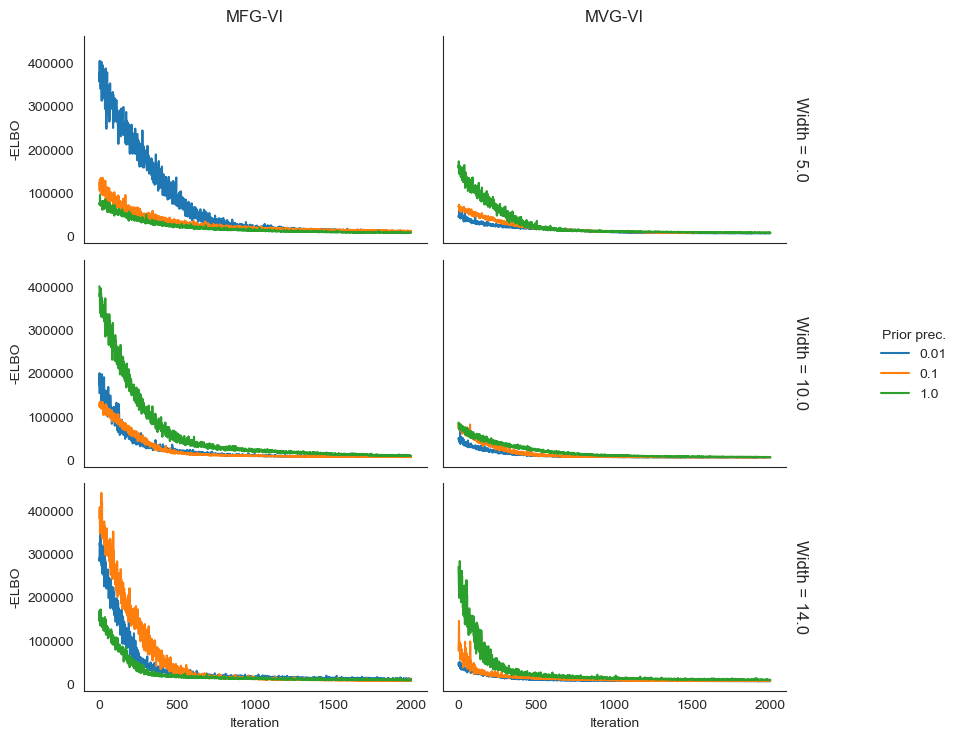

In [57]:
g = sns.FacetGrid(
    elbo_df,
    col="method_label",
    row="width",
    hue="precision_prior",
    sharey=True,
    sharex=True,
    height=2.5,
    aspect=1.5
)

g.map_dataframe(sns.lineplot, x="iteration", y="elbo")

g.add_legend(title="Prior prec.")
g._legend.set_bbox_to_anchor((1.16, 0.5))
g._legend.set_frame_on(False)


g.set_titles("")
g.set_axis_labels("Iteration", "-ELBO")

for ax, col in zip(g.axes[0], g.col_names):
    ax.set_title(col, fontsize=12, pad=10)

for ax, row in zip(g.axes[:, -1], g.row_names):
    ax.annotate(f"Width = {row}", xy=(1.02, 0.5), xycoords="axes fraction",
                rotation=270, ha="left", va="center", fontsize=12)

plt.tight_layout()
plt.savefig("figures/elbo_traces_by_method_width.png", dpi=300, bbox_inches="tight")
plt.show()

Plot Rhat histograms by width and prior precision:

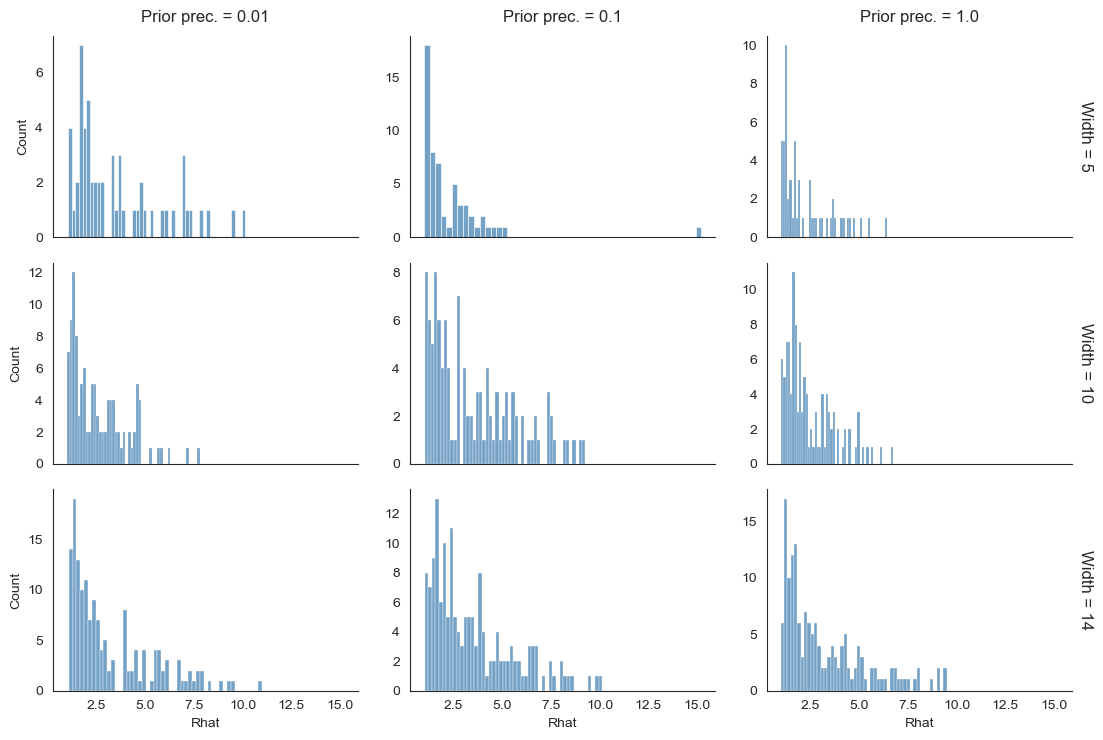

In [54]:
g = sns.FacetGrid(
    rhat_df,                 
    row="width",
    col="precision_prior",
    sharey=False,
    sharex=True,
    height=2.5,
    aspect=1.5
)

g.map_dataframe(sns.histplot, x="rhat", bins=50, kde=False, color="steelblue")

g.set_axis_labels("Rhat", "Count")

g.set_titles("")

for ax, row in zip(g.axes[:, -1], g.row_names):
    ax.annotate(f"Width = {row}", xy=(1.02, 0.5), xycoords="axes fraction",
                rotation=270, ha="left", va="center", fontsize=12)

for ax, col in zip(g.axes[0], g.col_names):
    ax.set_title(f"Prior prec. = {col}", fontsize=12, pad=10)

plt.tight_layout()
plt.savefig("figures/rhat_histograms.png", dpi=300, bbox_inches="tight")
plt.show()

Plot ESS histograms by width and prior precision:

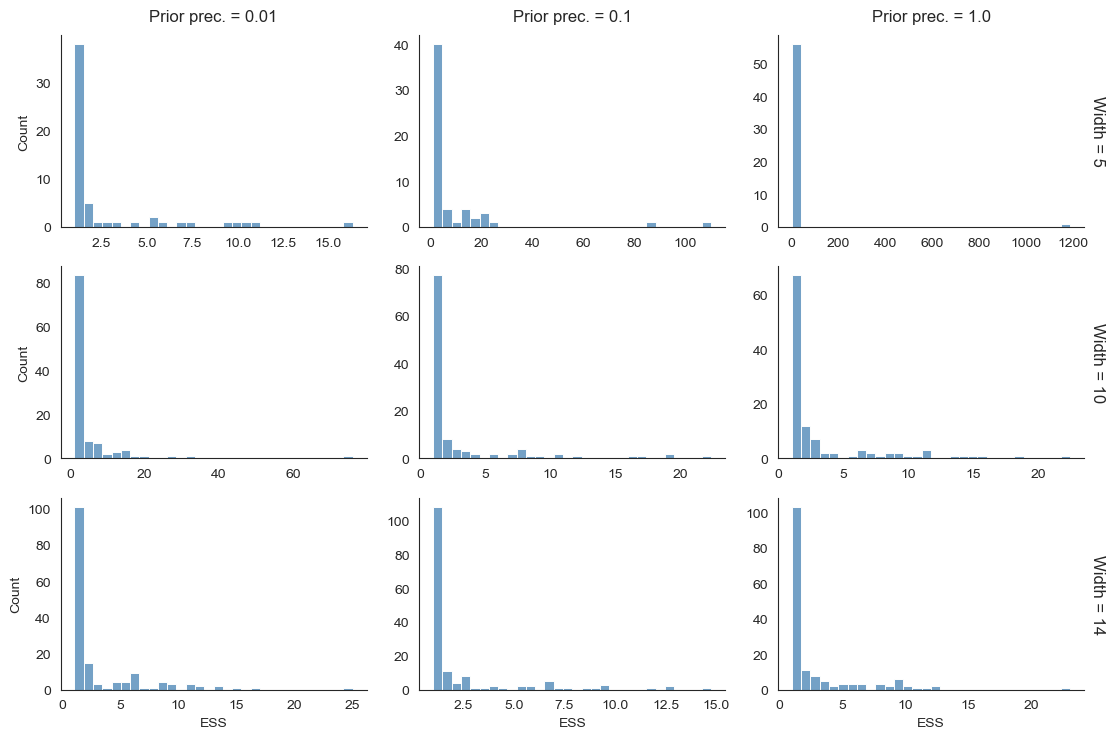

In [55]:
g = sns.FacetGrid(
    ess_df,                  
    row="width",
    col="precision_prior",
    sharey=False,
    sharex=False,
    height=2.5,
    aspect=1.5
)

g.map_dataframe(sns.histplot, x="ess", bins=30, kde=False, color="steelblue")

g.set_axis_labels("ESS", "Count")

g.set_titles("")

for ax, row in zip(g.axes[:, -1], g.row_names):
    ax.annotate(f"Width = {row}", xy=(1.02, 0.5), xycoords="axes fraction",
                rotation=270, ha="left", va="center", fontsize=12)

for ax, col in zip(g.axes[0], g.col_names):
    ax.set_title(f"Prior prec. = {col}", fontsize=12, pad=10)

plt.tight_layout()
plt.savefig("figures/ess_histograms.png", dpi=300, bbox_inches="tight")
plt.show()